In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [26]:
def damped_oscillator(x, y):
    """ODE system.
    dtheta/dx = v
    dv/dx = -sin(theta)
    """
    theta = y[:, 0:1]
    v = y[:, 1:]
    theta_prime = dde.grad.jacobian(y, x, i=0)
    v_prime = dde.grad.jacobian(y, x, i=1)
    return [theta_prime-v, v_prime+tf.sin(theta)]


def boundary(_, on_initial):
    return on_initial

def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2*2 * t),
            tf.sin(3*2 * t),
            tf.sin(4*2 * t),
            tf.sin(5*2 * t),
            tf.sin(6*2 * t),
        ),
        axis=1,
    )


In [29]:
geom = dde.geometry.TimeDomain(0, 15)
ic1 = dde.IC(geom, lambda X: 1, boundary, component=0)
ic2 = dde.IC(geom, lambda X: .9, boundary, component=1)
data = dde.data.PDE(geom, damped_oscillator, [ic1, ic2], 100, 2, num_test=100)

C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn("The balance properties of Sobol' points require "


In [41]:
layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)
# net.apply_feature_transform(input_transform)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.046600 s



C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:107: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\andre\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.410685 s



Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.37e-02, 4.72e-01, 1.00e+00, 8.10e-01]    [9.32e-02, 4.78e-01, 1.00e+00, 8.10e-01]    []  
1000      [1.27e-02, 1.22e-02, 2.27e-04, 2.47e-04]    [1.19e-02, 1.26e-02, 2.27e-04, 2.47e-04]    []  
2000      [7.62e-03, 8.03e-03, 7.94e-05, 7.68e-05]    [7.37e-03, 8.31e-03, 7.94e-05, 7.68e-05]    []  
3000      [6.12e-03, 6.03e-03, 4.51e-05, 4.17e-05]    [6.18e-03, 6.17e-03, 4.51e-05, 4.17e-05]    []  
4000      [5.03e-03, 5.25e-03, 3.45e-05, 2.94e-05]    [5.30e-03, 5.39e-03, 3.45e-05, 2.94e-05]    []  
5000      [4.33e-03, 4.67e-03, 2.44e-05, 2.07e-05]    [4.62e-03, 4.76e-03, 2.44e-05, 2.07e-05]    []  

Best model at step 5000:
  train loss: 9.04e-03
  test loss: 9.43e-03
  test metric: []

'train' took 4.487676 s

Compiling model...
'compile' took 0.304983 s

Training model...

Step      Train loss                           

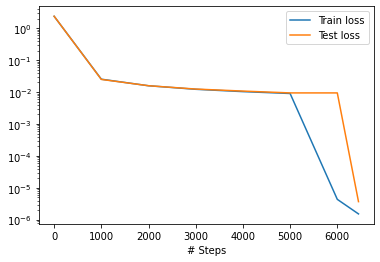

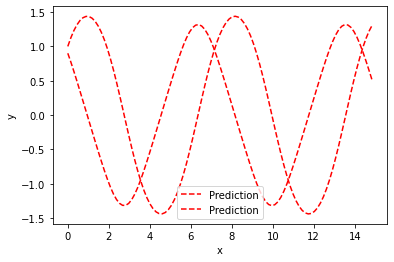

In [42]:
losshistory, train_state = model.train(epochs=5000)

model.compile("L-BFGS")
losshistory, train_state = model.train()

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

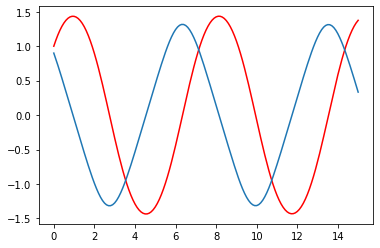

In [11]:
def ivp_oscillator(t,z):
    theta,v = z
    return v, -np.sin(theta)

x0,y0 = 1,.9
tn = 15
dt = .1
osc_sol = solve_ivp(ivp_oscillator, (0,tn), (x0,y0), method='RK45', t_eval=np.arange(0,tn+dt,dt))
plt.plot(osc_sol.t,osc_sol.y[0], color = 'r')
plt.plot(osc_sol.t,osc_sol.y[1])
plt.show()

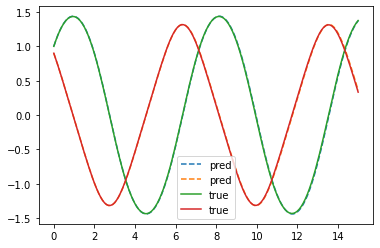

In [62]:
t = np.arange(0,15.1,.1).reshape(151, 1)
model_pred = model.predict(t)
plt.plot(t, model_pred, linestyle = 'dashed', label='pred')
plt.plot(osc_sol.t, osc_sol.y[0], label='true')
plt.plot(osc_sol.t, osc_sol.y[1], label='true')
plt.legend()
plt.show()

In [72]:
print('L2 relative error for theta', dde.metrics.l2_relative_error(model_pred[:,0],osc_sol.y[0]))
print('L2 relative error for v', dde.metrics.l2_relative_error(model_pred[:,1],osc_sol.y[1]))

L2 relative error for theta 0.013047569346014802
L2 relative error for v 0.013327129831354142
